In [1]:


from word_processing import Word
from abc import ABC, abstractmethod


class Population(ABC):

    def __init__(self, list_individuals: [], embedding, fit_function):
        self.population = list_individuals
        self.embedding = embedding
        self.fit_function = fit_function

    def mutating(self):
        self.population = [
            self.mutate_individual(individual)
            for individual in self.population
        ]

    def crossing(self):
        cross_results = [
            self.cross_individual(individual)
            for individual in self.population
        ]

        new_population = []
        for cross_result in cross_results:
            new_population += cross_result

        self.population = new_population

    @staticmethod
    def filter_copies(individuals: [[[Word]]]) -> [[[Word]]]:

        def equal_individuals(first, second):
            for index_row, row in enumerate(first):
                for index_word, word in enumerate(row):
                    if word.word != second[index_row][index_word]:
                        return False
            return True

        return list(
            filter(
                lambda individual: not any([equal_individuals(individual, other) for other in individuals]),
                individuals
            )
        )

    def selection(self, topn: int):
        fitted_individuals = [
            {
                'rate': self.fit_function(individual),
                'individual': individual
            }
            for individual in self.filter_copies(self.population)
        ]

        fitted_individuals.sort(key=lambda individual: individual['rate'], reverse=True)

        filtered_individuals = fitted_individuals[:topn]

        return self._get_population([rated_individual['individual'] for rated_individual in filtered_individuals]), \
               [ rated_individual['rate'] for rated_individual in filtered_individuals]

    @abstractmethod
    def cross_individual(self, individual):
        raise NotImplemented()

    @abstractmethod
    def mutate_individual(self, individual):
        raise NotImplemented()

    @abstractmethod
    def _get_population(self, individuals: []):
        raise NotImplemented()

    def size(self) -> int:
        return len(self.population)

    def print_3d_population(self):
        for index, individual in enumerate(self.population):
            print(f'Индивид {index}')
            for row in individual:
                print(' '.join([str(word) for word in row]))
            print()



In [2]:
class MockPopulation(Population):

    def _get_population(self, individuals: []):
        return MockPopulation(individuals, self.embedding, self.fit_function)

    def cross_individual(self, individual):
        if len(individual) == 1:
            return [individual]
        return [individual, individual[:len(individual) - 1]]

    def mutate_individual(self, individual):
        return individual

In [3]:
from word_processing import Word
from random import randint, choices

def copy(matrix):
    return [
        [item for item in row]
        for row in matrix
    ]
class SimplePopulation(Population):

    def _get_population(self, individuals: []):
        return SimplePopulation(individuals, self.embedding, self.fit_function)

    def cross_individual(self, individual):
        return [
            copy(individual),
            copy(individual)
        ]


    @staticmethod
    def equal_metres(word_metre: str, predict_metre: str) -> bool:
        if len(word_metre) != len(predict_metre):
            return False

        for index, syllable in enumerate(word_metre):
            predict_syllable = predict_metre[index]
            if (predict_syllable != '/') and (predict_syllable != syllable):
                return False

        return True

    def mutate_individual(self, individual):
        def mutate_word(word: Word):
            if randint(1, 10) == 3:
                word_metre = word.metre
                predicted_words = self.embedding.predict_next_word([word], 20)
                metre_approved_words = list(
                    filter(
                        lambda predicted_word: self.equal_metres(word_metre, Word(predicted_word[0]).metre),
                        predicted_words
                    )
                )
                if metre_approved_words:
                    words, weights = list(zip(*metre_approved_words))
                    return Word(
                        choices(words, weights)[0]
                    )
            return word

        return [
            [
                mutate_word(word)
                for word in row
            ]
            for row in individual
        ]


In [4]:

class Genetic:
    def __init__(self, population: Population):
        self.population_size = population.size()
        self.population = population
        self.history = []

    def next_population(self) -> Population:
        self.population.crossing()
        self.population.mutating()
        self.population, fit_history = self.population.selection(self.population_size)

        self.history.append(fit_history)

        return self.population

In [5]:
from word2vec_models import TaigaStihiModel
from generators import Word2VecGenerator

base_context = [word for word in 'любовь смерть'.split(' ')]
embedding = TaigaStihiModel()
generator = Word2VecGenerator(embedding, base_context)

In [6]:
five_yamb = '_/_/_/_/_/'
adam = generator.generate(metre_scheme=five_yamb)
eve = generator.generate(metre_scheme=five_yamb)

In [7]:
MockPopulation([adam, eve], lambda x:x, {}).print_3d_population()

Индивид 0
медленную бессмертна царствует
скорбь тьма
мрак кромешная
мгла кромешный

Индивид 1
вселенская поправ смертельная
паника тварь печаль смертельная
божья скука сладостная злая
штука тяжкая тишь жуть смертная



In [8]:
from meaning_classifier import MeaningClassifierCNNTaiga

classifier = MeaningClassifierCNNTaiga()


In [14]:
population = SimplePopulation([eve, eve, eve], embedding, classifier.classify_paragraph)
print('Первое поколение')
population.print_3d_population()

Первое поколение
Индивид 0
вселенская поправ смертельная
паника тварь печаль смертельная
божья скука сладостная злая
штука тяжкая тишь жуть смертная

Индивид 1
вселенская поправ смертельная
паника тварь печаль смертельная
божья скука сладостная злая
штука тяжкая тишь жуть смертная

Индивид 2
вселенская поправ смертельная
паника тварь печаль смертельная
божья скука сладостная злая
штука тяжкая тишь жуть смертная



In [15]:
genetic = Genetic(population)

In [16]:
for generation in range(10):
    print(f'Поколение {generation + 2}')
    genetic.next_population().print_3d_population()

Поколение 2
Индивид 0
энергия поправ смертельная
паника тварь печаль смертельная
божья скука сладостная злая
эта тяжкая тишь жуть смертная

Индивид 1
вселенская поправ смертельная
паника тварь печаль смертельная
божья скука сладостная злая
штука тяжкая тишь жуть смертная

Индивид 2
вселенская поправ смертельная
паника тварь печаль смертельная
божья скука сладостная злая
штука тяжкая тишь жуть смертная

Поколение 3
Индивид 0
энергия поправ смертельная
паника тварь печаль смертельная
божья скука сладостная злая
эта тяжкая тишь жуть смертная

Индивид 1
энергия поправ смертельная
паника тварь печаль смертельная
божья скука сладостная злая
эта тяжкая тишь жуть смертная

Индивид 2
вселенская поправ смертельная
паника тварь печаль смертельная
божья скука сладостная злая
эта тяжкая тишь жуть смертная

Поколение 4
Индивид 0
энергия поправ смертельная
паника тварь печаль смертельная
божья скука сладостная злая
эта самая тишь жуть смертная

Индивид 1
энергия поправ смертельная
страшная тварь печа

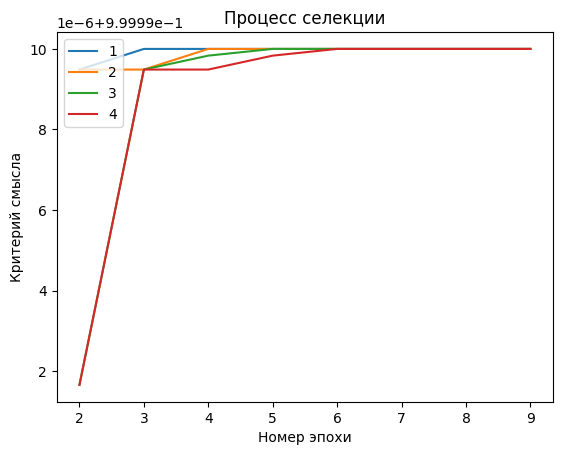

In [13]:
xs = range(len(genetic.history))
history = list(zip(*genetic.history))

import matplotlib.pyplot as plt

for individual in history:
    plt.plot(xs[2:], individual[2:])

plt.title('Процесс селекции')
plt.ylabel('Критерий смысла')
plt.xlabel('Номер эпохи')
plt.legend([index+1 for index in range(len(history))], loc='upper left')
plt.show()

In [ ]:
print(list(embedding.predict_next_word([Word('курить')], 1000)))